In [11]:
import pandas as pd
import numpy as np

from medangel.data import preprocessing
from medangel.models import model_builder
from medangel.features import feature_creation

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import matthews_corrcoef
from sklearn.feature_selection import RFE

from sklearn.feature_selection import RFECV


from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.transformers import FeatureSelector

from lightgbm import LGBMClassifier

import re

import time

from tqdm import tqdm

In [12]:
features,y = preprocessing.load_feature_data()

classifier__num_leaves = 80
classifier__n_estimators = 250
classifier__max_depth = 7
classifier__boosting_type = 'goss'
augmenter__fdr_level = 0.03


#clf = LGBMClassifier(random_state=42,n_jobs=5,device_type = 'gpu',max_bin = 64)
clf = LGBMClassifier(random_state=42,n_jobs=5,device_type = 'gpu',max_bin = 64,num_leaves=classifier__num_leaves,
    n_estimators=classifier__n_estimators,max_depth=classifier__max_depth,boosting_type=classifier__boosting_type)
trfm = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('augmenter',FeatureSelector(fdr_level=0.03,n_jobs=5))
])

y_temp = y.loc[y.index.isin(features.index)]
features = features.loc[y_temp.index]
x_array = np.array(features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)))
y_array = np.array(y_temp["label_shifted"])

#selector = RFE(clf,n_features_to_select = 9,step = 10)
selector = RFECV(clf,step = 20,n_jobs = 5,min_features_to_select=10,cv = 5)
trfm.fit(x_array,y_array)

Pipeline(steps=[('sampler', RandomUnderSampler(random_state=42)),
                ('augmenter', FeatureSelector(fdr_level=0.03, n_jobs=5))])

In [13]:
x_array[trfm['sampler'].sample_indices_,10]
relevant_feature_names = features.iloc[:,trfm.named_steps["augmenter"].relevant_features].columns

In [14]:
relevant_feature_names

Index(['temperature__sum_values',
       'temperature__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)',
       'temperature__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)',
       'temperature__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)',
       'temperature__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
       'temperature__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)',
       'temperature__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"',
       'temperature__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"',
       'temperature__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"',
       'temperature__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)',
       ...
       'temperature__symmetry_looking__r_0.65',
       'temperature__symmetry_looking__r_0.6000000000000001',
       'temperature__fft_coefficient__attr_"real"__coeff_4',
       'temperature__symmetry_looking__r_0.2',
       'temperatu

In [15]:
x = x_array[trfm['sampler'].sample_indices_,:]

In [16]:
x = x[:,trfm.named_steps["augmenter"].relevant_features]

In [17]:
len(x[:,1])

17090

In [18]:
y = y_array[trfm['sampler'].sample_indices_]

In [19]:
selector.fit(x,y)

RFECV(cv=5,
      estimator=LGBMClassifier(boosting_type='goss', device_type='gpu',
                               max_bin=64, max_depth=7, n_estimators=250,
                               n_jobs=5, num_leaves=80, random_state=42),
      min_features_to_select=10, n_jobs=5, step=20)

In [20]:
selector.n_features_

488

In [21]:
len(selector.ranking_)

528

In [22]:
rel_features_dict = {"feature":relevant_feature_names,
                    "ranking":selector.ranking_}
rel_features = pd.DataFrame(rel_features_dict)

In [23]:
top_9 = rel_features[rel_features.ranking == 1].feature

In [24]:
top_9

0                                temperature__sum_values
1      temperature__cwt_coefficients__coeff_1__w_10__...
2      temperature__cwt_coefficients__coeff_1__w_5__w...
3      temperature__cwt_coefficients__coeff_1__w_2__w...
4      temperature__cwt_coefficients__coeff_0__w_20__...
                             ...                        
520    temperature__fft_coefficient__attr_"real"__coe...
522    temperature__augmented_dickey_fuller__attr_"us...
524    temperature__fft_coefficient__attr_"real"__coe...
525                       temperature__number_peaks__n_3
527             temperature__ratio_beyond_r_sigma__r_1.5
Name: feature, Length: 488, dtype: object

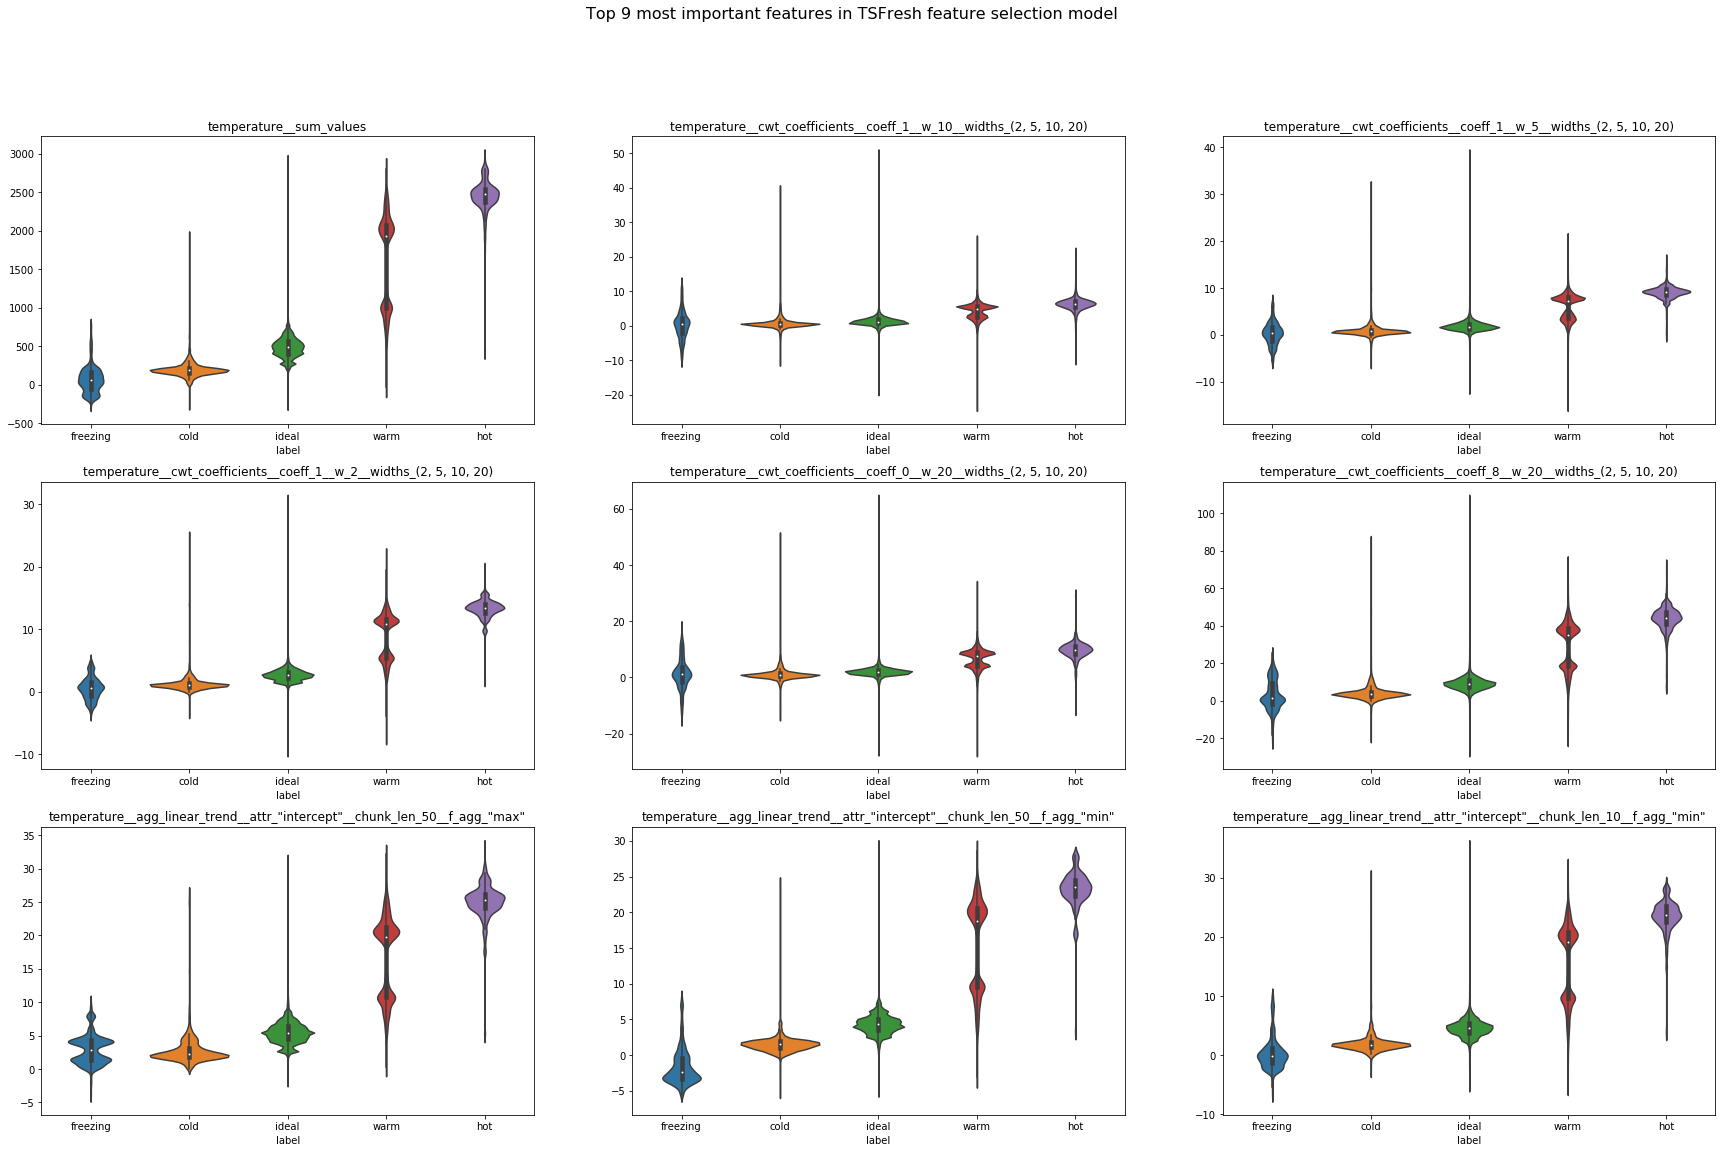

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,axs = plt.subplots(3,3)
fig.set_size_inches(30,18)
fig.suptitle("Top 9 most important features in TSFresh feature selection model",fontsize=16)
imp = 0
xy_matrix = features
xy_matrix["label"] = y_temp.label_shifted
for i in range(3):
    for j in range(3):
        sns.violinplot(x="label",y=top_9.iloc[imp], data = xy_matrix, ax=axs[i,j],order=["freezing","cold","ideal","warm","hot"])
        axs[i,j].set_ylabel('')
        axs[i,j].set_title(top_9.iloc[imp])
        imp +=1

In [35]:
top_9.head(15)

0                               temperature__sum_values
1     temperature__cwt_coefficients__coeff_1__w_10__...
2     temperature__cwt_coefficients__coeff_1__w_5__w...
3     temperature__cwt_coefficients__coeff_1__w_2__w...
4     temperature__cwt_coefficients__coeff_0__w_20__...
5     temperature__cwt_coefficients__coeff_8__w_20__...
6     temperature__agg_linear_trend__attr_"intercept...
7     temperature__agg_linear_trend__attr_"intercept...
8     temperature__agg_linear_trend__attr_"intercept...
9     temperature__cwt_coefficients__coeff_9__w_5__w...
10    temperature__cwt_coefficients__coeff_9__w_10__...
11    temperature__cwt_coefficients__coeff_9__w_20__...
12    temperature__agg_linear_trend__attr_"intercept...
13    temperature__agg_linear_trend__attr_"intercept...
14    temperature__cwt_coefficients__coeff_10__w_5__...
Name: feature, dtype: object

In [36]:
selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Optimal number of features : 488


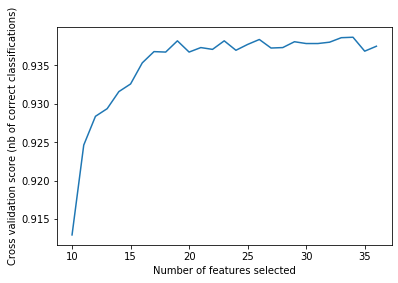

In [42]:
print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(10,
               len(selector.grid_scores_) + 10),
         selector.grid_scores_)
plt.show()

In [39]:
selector.grid_scores_

array([0.91293154, 0.92463429, 0.92837917, 0.9293739 , 0.93159743,
       0.93259216, 0.93534231, 0.93680515, 0.93674664, 0.93820948,
       0.93674664, 0.93733177, 0.93709772, 0.93820948, 0.93698069,
       0.93774137, 0.93838502, 0.93727326, 0.93733177, 0.93809245,
       0.9378584 , 0.9378584 , 0.93803394, 0.93861908, 0.93867759,
       0.93686366, 0.93750731])

In [53]:
selector.estimator.feature_importances_

NotFittedError: No feature_importances found. Need to call fit beforehand.